In [17]:
import os
from copy import deepcopy

figure_dir = os.getcwd() + '/022025_experiment/figures'

In [18]:
from default import *
%cd -q {PROJECT_HOME}

In [19]:
PORT = 5000

In [20]:
import numpy as np
import torch
import mlflow
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from models.architecture import MLP
from models.processing import StandardScaler
from torch import nn, dtype

from losses import StiffnessToLoadLoss

import ast

import torchmetrics.functional.regression as R
from dataset import FixedPrattTrussDatasetSingleTarget

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from tools.mlflow import BasicDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [21]:
ds = FixedPrattTrussDatasetSingleTarget('data/dataset/pratt_truss_bridge/single_ea/train_100.hdf5')
k_s = (int(ds.stiffness_matrix[0].__len__() ** .5),) * 2
k_ref = ds.stiffness_matrix[0].reshape(k_s).astype(np.float64)
k_ref /= ds[0][1]
k_ref[[0, 1, 17], [0, 1, 17]] = 1
#k_ref[k_ref.abs() < 1e-9] = 0
k_ref = k_ref.to(torch.float32).to(device)

# Train procedures

In [22]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = k_ref * target_pred.unsqueeze(-1)
    k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

    optimizer.zero_grad()
    loss = criterion(k_pred*1e-6,
                     u_from_x(input, 8)*1e3,
                     q_from_x_q(input,q,8)*1e-3)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = k_ref * target_pred.unsqueeze(-1)
        k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

        loss = criterion(k_pred*1e-6,
                     u_from_x(input, 8)*1e3,
                     q_from_x_q(input,q,8)*1e-3)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, dataset_log, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': lr,
            'criterion': criterion.__name__,
        })

        # Dataset information login
        for context, dataset in dataset_log.items():
            mlflow.log_input(dataset, context=context)

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

# Hyperparameter tuning

# Training

## Model capacity

### Tuning

In [23]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss_no_noise_model_capacity")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 100
    LR = 5e-3

    log_step = -1

    kfold = 5
    n_layers_values = [2, 3, 4]
    n_neurons_values = [30, 40, 60, 80, 100]
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for n_layers in n_layers_values:
            for n_neurons in n_neurons_values:
                for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                    hidden_dims = [n_neurons for _ in range(n_layers)]
                    train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                    future = executor.submit(trial_routine, None, train,
                                             {
                                                 'input_dim': 65,
                                                 'hidden_dims': hidden_dims,
                                                 'output_dim': 1,
                                                 'activation': "relu",
                                                 'activation_params': None,
                                                 'dropout': 0.0,
                                                 'batch_norm': False,
                                                 'layer_norm': False,
                                                 'normalization_params': None,
                                                 'output_activation': None,
                                                 'output_activation_params': None
                                             },
                                             train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                             N_EPOCH,
                                             torch.optim.Adam, LR, StiffnessToLoadLoss,
                                             {
                                                 'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                          "60m long 7,5m high pratt truss"),
                                             }, kfold, log_step)
                    futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run big-hawk-950 at: http://127.0.0.1:5000/#/experiments/140917482574233717/runs/d4ebd6cffdde4ec892ce18ef0442fcf8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/140917482574233717
🏃 View run righteous-shrew-549 at: http://127.0.0.1:5000/#/experiments/140917482574233717/runs/3ad78a20d7ce488ab708d9e3dce2fe30
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/140917482574233717
🏃 View run stylish-vole-394 at: http://127.0.0.1:5000/#/experiments/140917482574233717/runs/1801e64e4047464fb0a6b611d9a18213
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/140917482574233717
🏃 View run abrasive-crow-486 at: http://127.0.0.1:5000/#/experiments/140917482574233717/runs/256dbab951b34424b577a95b36bbafda
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/140917482574233717
🏃 View run masked-shrimp-370 at: http://127.0.0.1:5000/#/experiments/140917482574233717/runs/20853666d5244623a2a51a8e571a7bf4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/14091748

### Exploring the results

In [24]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss_no_noise_model_capacity")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set()
for m in runs_df['params.n_hidden_layers'].unique():
    for n in runs_df['params.hidden_layers_size'].unique():
        combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for m, n in combinations:
    run_ids = runs_df[(runs_df['params.n_hidden_layers'] == m) &
                      (runs_df['params.hidden_layers_size'] == n)]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(m, n)][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

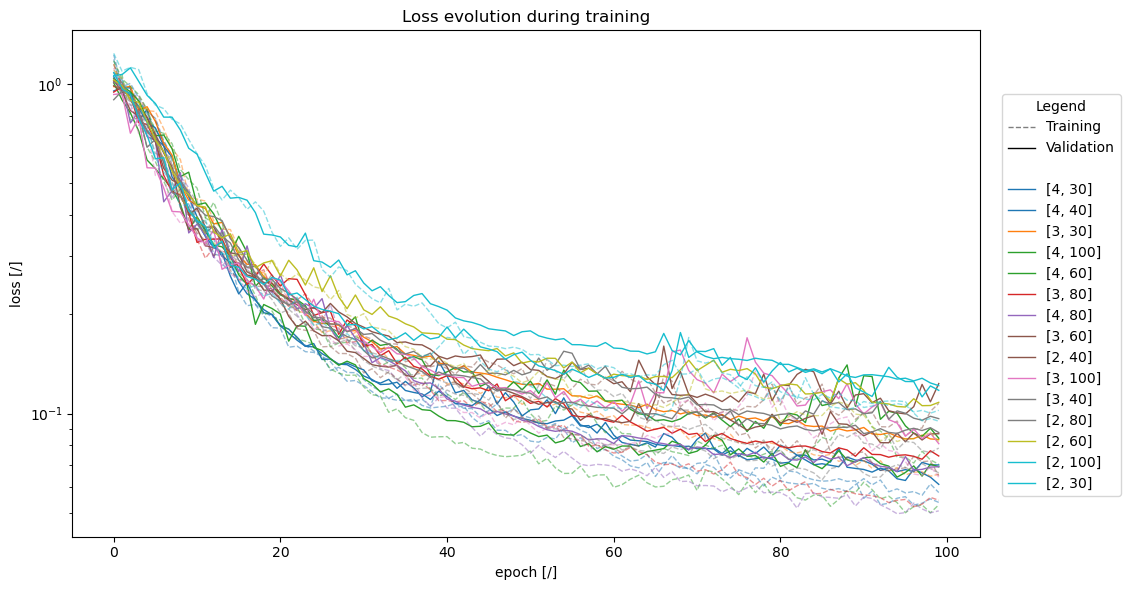

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, capacity in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[capacity]['train_loss'])
    h = ax.plot(np.arange(l), results[capacity]['train_mape'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[capacity]['val_mape'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [str([int(x) for x in cfg]) for cfg in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

## Activation function

In [31]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss_no_noise_activation_function")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 200
    LR = 5e-4

    log_step = -1

    kfold = 5
    activation_values = ['relu', 'gelu', 'tanh', 'sigmoid', 'softplus',
                         'leaky_relu', 'leaky_relu', 'leaky_relu',
                         'leaky_relu', 'leaky_relu', 'leaky_relu',
                         'leaky_relu']
    activation_params_values = [None, None, None, None, None,
                                {'negative_slope': 1e-1}, {'negative_slope': 1e-2}, {'negative_slope': 1e-3},
                                {'negative_slope': 1e-4}, {'negative_slope': 1e-5}, {'negative_slope': 1e-6},
                                {'negative_slope': 1e-7}]
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for activation, activation_params in zip(activation_values, activation_params_values):
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': activation,
                                             'activation_params': activation_params,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss,
                                         {
                                             'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run kindly-dog-831 at: http://127.0.0.1:5000/#/experiments/690381543755434944/runs/8d882b0896ed4421b25116e08c33acdb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/690381543755434944
🏃 View run bedecked-horse-445 at: http://127.0.0.1:5000/#/experiments/690381543755434944/runs/b1049752e6774066ace73dced96fe8fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/690381543755434944
🏃 View run rebellious-worm-498 at: http://127.0.0.1:5000/#/experiments/690381543755434944/runs/52de4780d66942928f857c735c06e0b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/690381543755434944
🏃 View run charming-cub-441 at: http://127.0.0.1:5000/#/experiments/690381543755434944/runs/eafa0eee56824078ab16c62f1474d0d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/690381543755434944
🏃 View run adventurous-dog-699 at: http://127.0.0.1:5000/#/experiments/690381543755434944/runs/a41f24a2cf3a43319d7e2638dc358adb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/690

### Exploring the results

In [32]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss_no_noise_activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for k in combinations:
    (act, params) = k
    run_ids = runs_df[(runs_df['params.activation'] == act)
                      & (runs_df['params.activation_params'] == params)]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

if ('leaky_relu', 'None') in results:
    results[('leaky_relu', "{'negative_slope': 0.01}")] = results[('leaky_relu', 'None')]
    del results[('leaky_relu', 'None')]

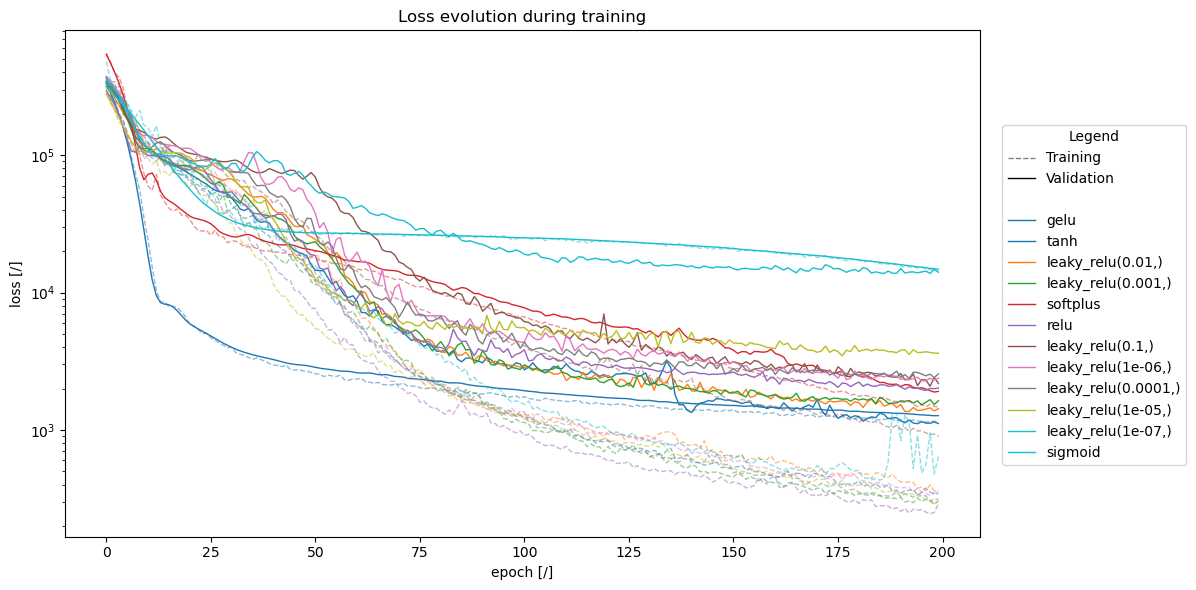

In [34]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_loss']), k) for k, v in results.items()])]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[k]['train_loss'])
    h = ax.plot(np.arange(l), results[k]['train_loss'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[k]['val_loss'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles

labels = []
for act, params in configs:
    s = act
    if params != "None":
        s += tuple(ast.literal_eval(params).values()).__str__()
    labels.append(s)

all_labels = ['Training', 'Validation', ''] + labels

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

## Learning rate

In [35]:
if False:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss_no_noise_learning_rate")

    TRAIN_BATCH_SIZE = 512
    VAL_BATCH_SIZE = 256
    N_EPOCH = 200
    LR = 5e-4

    kfold = 5
    dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5"
    ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for LR in sorted(np.hstack([f * np.logspace(-5, -2, 4) for f in [1, 2.5, 5, 7.5]])):
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss,
                                         {
                                             'training': BasicDataset('2_000', dataset_path, 2_000, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

2025/03/17 15:50:14 INFO mlflow.tracking.fluent: Experiment with name 'StiffnessToLoadLoss_no_noise_learning_rate' does not exist. Creating a new experiment.


🏃 View run nimble-doe-151 at: http://127.0.0.1:5000/#/experiments/289746832936831440/runs/91e8aacc8d5e4c36ac7ef971c5dd9359
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/289746832936831440
🏃 View run mysterious-robin-543 at: http://127.0.0.1:5000/#/experiments/289746832936831440/runs/e6ea67c2a6d4470fbd69b7a6daf7df2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/289746832936831440
🏃 View run thoughtful-lynx-545 at: http://127.0.0.1:5000/#/experiments/289746832936831440/runs/328a426181d84e4cb4f0e96130e58ff0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/289746832936831440
🏃 View run defiant-calf-690 at: http://127.0.0.1:5000/#/experiments/289746832936831440/runs/d3eff691e9bf4444bdacce19ddabae0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/289746832936831440
🏃 View run thundering-rook-103 at: http://127.0.0.1:5000/#/experiments/289746832936831440/runs/2a5856f104614332a5550ffb942dc7ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2

### Exploring the results

In [44]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss_no_noise_learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for lr in combinations:
    run_ids = runs_df[runs_df['params.learning_rate'] == lr]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

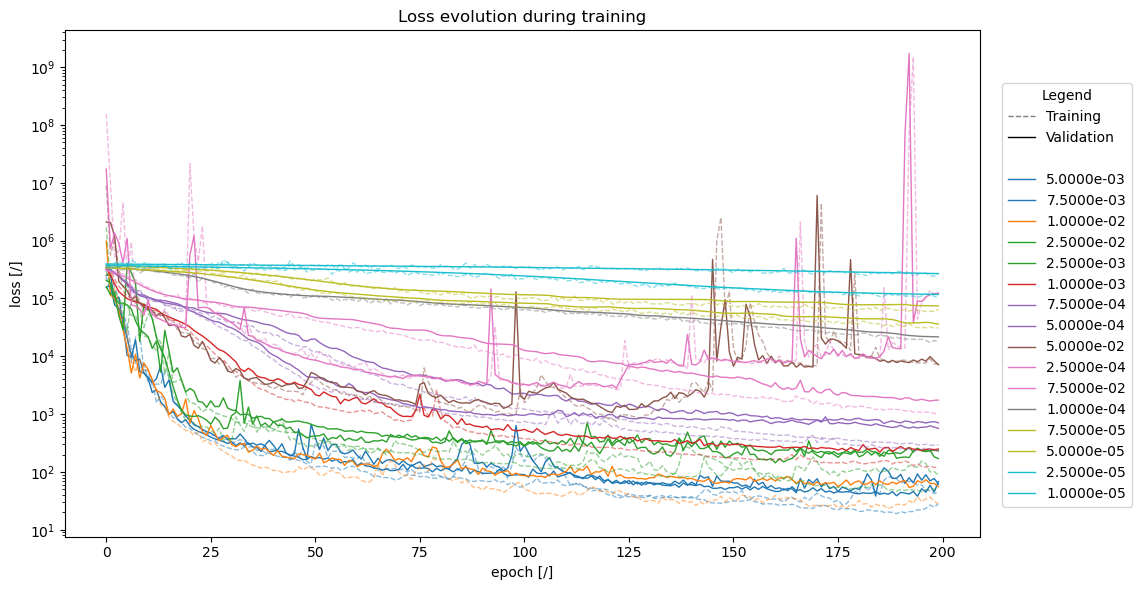

In [45]:
# Your existing code for preparing the data
configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
metric = 'loss'
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    l = len(results[k][f'train_{metric}'])
    h = ax.plot(np.arange(l), results[k][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(l), results[k][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [f"{float(c):.4e}" for c in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

# Testing

In [46]:
if True:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss_no_noise_dataset_size")

    VAL_BATCH_SIZE = 8192
    N_EPOCH = 200
    log_step = -1
    LR = 5e-3
    kfold = 5

    sizes = [100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
    batch_size_values = [int(min(np.power(2, np.floor(np.log2(n)) - 1), 4096)) for n in sizes]
    dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
            size = sizes[i]
            ds = FixedPrattTrussDatasetSingleTarget(dataset_path)
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss,
                                         {
                                             'training': BasicDataset(f'{size}', dataset_path, size, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step)
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run able-midge-590 at: http://127.0.0.1:5000/#/experiments/390102545100465801/runs/18ae187cf0bf41ffb14dfe71d0347c6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/390102545100465801
🏃 View run bright-turtle-614 at: http://127.0.0.1:5000/#/experiments/390102545100465801/runs/4ed926602599457b97560017e0820f1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/390102545100465801
🏃 View run serious-wren-830 at: http://127.0.0.1:5000/#/experiments/390102545100465801/runs/6d26194e2ea54e8cb85a8368a47288a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/390102545100465801
🏃 View run redolent-deer-668 at: http://127.0.0.1:5000/#/experiments/390102545100465801/runs/c7c346643535445f993686a30e27d040
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/390102545100465801
🏃 View run sassy-squirrel-46 at: http://127.0.0.1:5000/#/experiments/390102545100465801/runs/02e7f43c985f41d8ad623ba2666284a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/39010254

### Results exploration

In [47]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss_no_noise_dataset_size")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

combinations = set(runs_df['params.train_size'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in combinations}
for size in combinations:
    run_ids = runs_df[runs_df['params.train_size'] == size]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

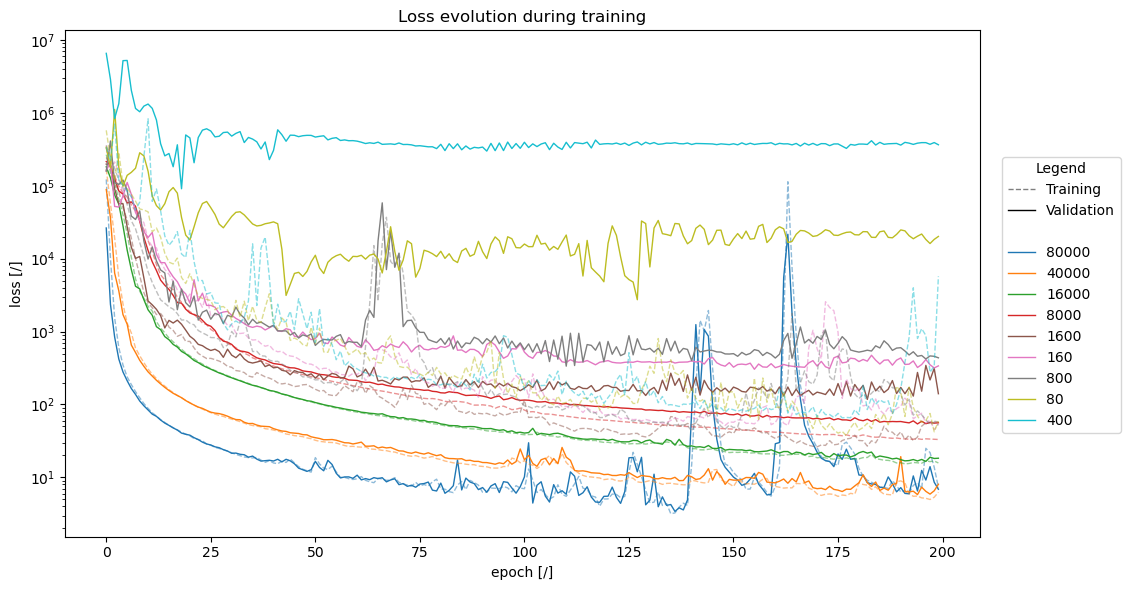

In [54]:
# Your existing code for preparing the data
configs = sorted([(np.min(v['val_loss']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(configs)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data but collect the handles for the legend
config_handles = []
for i, k in enumerate(configs):
    # Store only the validation line handles for the legend
    h = ax.plot(np.arange(len(results[k]['train_mape'])), results[k]['train_mape'], alpha=.5, ls='--', lw=1, c=c[i])[0]
    h2 = ax.plot(np.arange(len(results[k]['val_mape'])), results[k]['val_mape'], ls='-', lw=1, c=c[i])[0]
    config_handles.append(h2)

# Create custom handles for the line style legend
line_style_handles = [
    Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
    Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
]

# Get the current position and size of the axis
box = ax.get_position()
# Reduce the width of the axis to make room for the legend
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Combine both sets of handles and labels
all_handles = line_style_handles + config_handles
all_labels = ['Training', 'Validation', ''] + [f"{int(c)}" for c in configs]

# Create a single legend with both line styles and configurations
plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
              title="Legend")

ax.set_title("Loss evolution during training")
ax.set_yscale('log')
ax.set_ylabel("loss [/]")
ax.set_xlabel("epoch [/]")
plt.tight_layout()
# Adjust right padding to make room for the legend
plt.show()

# Test on "real" data

In [49]:
if True:
    mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
    mlflow.set_experiment("StiffnessToLoadLoss_no_noise_test_noise")

    VAL_BATCH_SIZE = 8192
    N_EPOCH = 300
    log_step = -1
    LR = 5e-3
    kfold = -1

    sizes = [100, 200, 500, 1000, 2000, 10000, 20000]
    batch_size_values = [int(min(np.power(2, np.floor(np.log2(n)) - 1), 4096)) for n in sizes]
    dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for f in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
                size = sizes[i]
                train_dataset = FixedPrattTrussDatasetSingleTarget(dataset_path)
                test_dataset = FixedPrattTrussDatasetSingleTarget(
                    "data/dataset/pratt_truss_bridge/single_ea/test_20000.hdf5",
                    f_noise_length=None,
                    f_noise_loads=lambda size: np.random.normal(1, f * 0.005, size=size),
                    f_noise_strain=lambda size: np.random.normal(1, f * 0.005, size=size),
                    f_noise_displacement=lambda size: np.random.normal(1, f * 0.005, size=size)
                )
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': [30 for _ in range(4)],
                                             'output_dim': 1,
                                             'activation': 'gelu',
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None
                                         },
                                         train_dataset, test_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss,
                                         {
                                             'training': BasicDataset(f'{size}', dataset_path, size, kfold,
                                                                      "60m long 7,5m high pratt truss"),
                                             'test': BasicDataset(f'20_000',
                                                                  "data/dataset/pratt_truss_bridge/single_ea/test_20000.hdf5",
                                                                  20000, kfold, "60m long 7,5m high pratt truss"),
                                         }, kfold, log_step, {'noise_factor': f})
                futures.append(future)

        # Ensure all processes complete execution
        for future in futures:
            future.result()

🏃 View run spiffy-donkey-73 at: http://127.0.0.1:5000/#/experiments/623296011662521052/runs/f909b1aec70b4efeacd65a70818b7b2a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/623296011662521052
🏃 View run rebellious-ant-251 at: http://127.0.0.1:5000/#/experiments/623296011662521052/runs/1bb94952327048b7a3c360034ec9164a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/623296011662521052
🏃 View run marvelous-toad-829 at: http://127.0.0.1:5000/#/experiments/623296011662521052/runs/d6381fbcbf594ce38ac1968a1722bc2b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/623296011662521052
🏃 View run gaudy-kite-514 at: http://127.0.0.1:5000/#/experiments/623296011662521052/runs/b235fdb497e544fbb50c6e31c0b24e5d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/623296011662521052
🏃 View run valuable-asp-782 at: http://127.0.0.1:5000/#/experiments/623296011662521052/runs/9d3d81e5f15145dd8768491d7fd8c5d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6232960

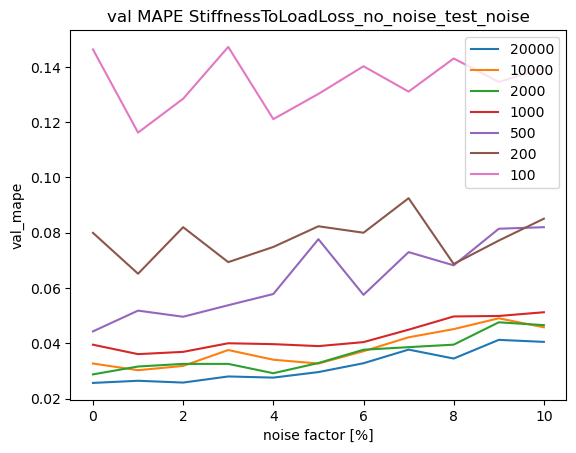

In [50]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("StiffnessToLoadLoss_no_noise_test_noise")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

noise_factors = {}
for size in runs_df['params.train_size'].unique():
    df = runs_df[runs_df['params.train_size'] == size]
    noise_factors[size] = []
    for noise in df['params.noise_factor'].unique():
        noise_factors[size].append(noise)
    noise_factors[size].sort(key=lambda k: float(k))

values = {}
client = mlflow.tracking.MlflowClient()
for size, factors in noise_factors.items():
    values[size] = {metric_name: [] for metric_name in metrics_names}
    for factor in factors:
        run_ids = runs_df[(runs_df['params.train_size'] == size) & (runs_df['params.noise_factor'] == factor)][
            'run_id']
        for metric_name in metrics_names:
            metrics_values = [[m.value for m in client.get_metric_history(run_id, metric_name)] for run_id in
                              run_ids]
            if 'r2' in metric_name:
                values[size][metric_name].append(np.max(np.hstack(metrics_values)))
            else:
                values[size][metric_name].append(np.min(np.hstack(metrics_values)))

for metric_name in ['val_mape']:
    fig, ax = plt.subplots()
    for size in values.keys():
        ax.plot([int(f) for f in noise_factors[size]], values[size][metric_name], label=size)
    ax.set_title(f"val MAPE StiffnessToLoadLoss_no_noise_test_noise")
    ax.legend()

    ax.set_ylabel(metric_name)
    ax.set_xlabel("noise factor [%]")